In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

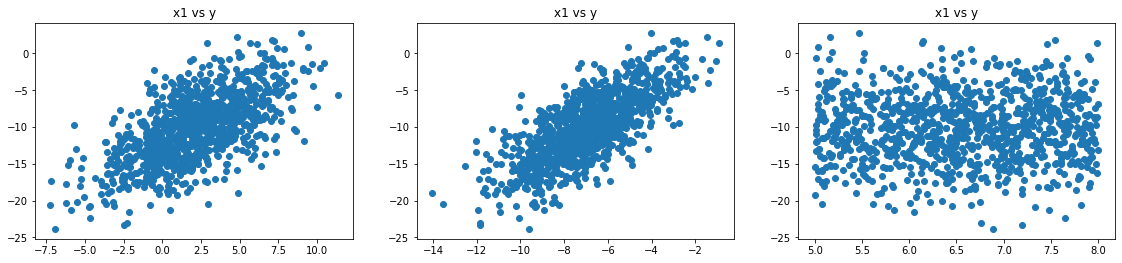

In [196]:
x1 = np.random.randn(1000,)*3+2
x2 = np.random.randn(1000,)*2-7
x3 = np.random.random((1000,))*3+5
y = x1 + x2 + np.random.randn(1000,)*0.5 + 0.75*x2
X = np.c_[x1,x2,x3]
fig,ax = plt.subplots(1,3)
ax[0].scatter(x1,y);ax[0].set_title('x1 vs y');
ax[1].scatter(x2,y);ax[1].set_title('x1 vs y');
ax[2].scatter(x3,y);ax[2].set_title('x1 vs y');
plt.subplots_adjust(bottom=0, left = 0,right=2.5, top=0.75,hspace = 0.5 )


### What MSEs do we get back from the normal models?

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def get_MSE(X,y,*model_type):
    n = len(y)
    for i, mod in enumerate(model_type):
        mod.fit(X,y)
        predictions = mod.predict(X)
        MSE = np.sum((predictions-y)**2)/n
        MSE_canned = mean_squared_error(predictions,y)
        print(mod.__class__.__name__ + " has manual MSE of "+str(MSE)+ ' and canned MSE is ' + str(MSE_canned))
mod1 = DecisionTreeRegressor()
mod2 = LinearRegression()
mod3 = RandomForestRegressor()
get_MSE(X,y,mod1,mod2,mod3)

DecisionTreeRegressor has manual MSE of 0.0 and canned MSE is 0.0
LinearRegression has manual MSE of 0.21387441747431876 and canned MSE is 0.21387441747431876
RandomForestRegressor has manual MSE of 0.2908899591196395 and canned MSE is 0.2908899591196395


In [176]:
def sum_sq_error(x):
    n = len(x)
    x_bar = np.mean(x)
    sum_sq_err = np.sum([(xi-x_bar)**2 for xi in x])
    return(sum_sq_err)

sum_sq_error(x1)
#np.var(x1)

944.4702636381716

In [177]:
new_X = x1
idxs = new_X.argsort()
n = new_X.shape[0]
left_sse = np.array([sum_sq_error(y[idxs][:i]) for i in range(1, y.shape[0])])
right_sse = np.array([sum_sq_error(y[idxs][i:]) for i in range(1, y.shape[0])])
total_sse = left_sse + right_sse

min_idx = total_sse.argmin() #find index with least impurity (most purity)
threshold = (new_X[idxs][min_idx] + X[idxs][min_idx+1]) / 2. #take actual value of X that has the index = to leas impurity
                                                        #and then look for the next value up. The middle of that
                                                        #is where we will split the column.

In [114]:
(new_X[idxs][min_idx] + new_X[idxs][min_idx+1]) / 2. 

0.31402774769795694

In [180]:
def find_best_split(X, y):
    """This function will find the best split and return the impurity and index.
    
    This function will take in a vector X and identify the best split according to that
    vector, evaluated on how well it partitions y into pure groups. It will evaluate the
    gini impurity at each possible split and return the best split.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n,)
        The data used to order y by when finding the best partition. This is typically
        a single column from the data the tree is being learned over.
    
    y : numpy.ndarray, shape=(n,)
        The labels for the data.
    
    Returns
    -------
    min_total_impurity : double
        The total impurity across both sides of the split for the best split
    
    threshold : double
        The threshold at which one would split.
        
    """
    
    idxs = X.argsort()
    n = X.shape[0]
    left_sse = np.array([sum_sq_error(y[idxs][:i]) for i in range(1, y.shape[0])])
    right_sse = np.array([sum_sq_error(y[idxs][i:]) for i in range(1, y.shape[0])])
    total_sse = left_sse + right_sse
    
    min_idx = total_sse.argmin() #find index with least impurity (most purity)
    threshold = (X[idxs][min_idx] + X[idxs][min_idx+1]) / 2. #take actual value of X that has the index = to leas impurity
                                                            #and then look for the next value up. The middle of that
                                                            #is where we will split the column.
    return total_sse.min(), threshold

In [187]:
def find_best_feature(X, y):
    """This helper function will identify the best split across all features.
    
    When deciding where to make the best split, all features must be considered. This function
    will call `find_best_split` on each feature, identify the feature yielding the best split,
    and return that.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n, d)
        The dataset that this section of the tree is being learned on.
    
    y : numpy.ndarray, shape=(n,)
        The corresponding labels for the data
    
    Returns
    -------
    best_feature : int
        The index of the feature the best split was found in.
    
    best_threshold : double
        The threshold identified for that feature, where samples that are less than this
        value go to the left in the tree, and samples that are greater than or equal to
        go to the right in the tree.
    
    best_impurity : double
        The total impurity for this split, equal to the summation of the impurities on
        either side of the split.
    """
    
    best_sse, best_split, best_feature, best_threshold = 1e+16, None, None, None
    for feature in range(X.shape[1]):
        sse, threshold = find_best_split(X[:,feature], y)
        if sse < best_sse:
            best_sse, best_threshold, best_feature, = sse, threshold, feature
    
    return best_feature, best_threshold, best_sse

In [191]:
def recursively_split(X, y):
    """This is the main function to learn a tree, through recursive splits.
    
    A tree is a recursive structure, in that each inner node within the tree is itself
    a tree. Since only portions of the dataset are sent either left or right at each
    split, the decision tree building task itself is recursive over these partitions
    of the dataset. For example, if I am building a tree over 100 samples originally and
    send 63 of them to the left child, I then repeat the same opertions over only those 63
    samples to and partition the dataset again, accordingly. The tree is thus built in a
    depth first manner.
    
    Parameters
    ----------
    X : numpy.ndarray, shape=(n, d)
        The dataset that this section of the tree is being learned on
    
    y : numpy.ndarray, shape=(n,)
        The corresponding labels for the data.
    
    Returns
    -------
    tree : tuple of tuples
        Each tuple corresponds to (feature, threshold, value) for a particular node in the tree.
        If the node is a leaf node, then feature and threshold are set to None, and value is the
        value that is predicted at this leaf.
    """
    
    
    if len(y) == 1:
        return ((None, None, y[0]),)

    #counts = np.unique(y, return_counts=True)[1]
    value = np.mean(y)
    
    feature, threshold, sum_sq_err = find_best_feature(X, y)
    
    li = X[:,feature] < threshold  #gather part of X that is less than threho
    ri = X[:,feature] >= threshold
    
    if li.sum() == 0 or ri.sum() == 0: #if either side of the branch is empty then we are done
        return ((None, None, value),)
    
    return ((feature, threshold, value),) + \
            recursively_split(X[li], y[li]) + \
            recursively_split(X[ri], y[ri]) 

In [235]:
class DecisionTree(object):
    """This is the decision tree object that we are going to build together.
    
    This estimator will ultimately have two main methods, `fit` and `predict`,
    where `fit` will build a decision tree based on labeled training data that
    is passed in, and `predict` will assign labels to unlabeled samples in
    the future.
    """
    
    def __init__(self):
        pass
    
    def _recursively_split(self, X, y):
        """This is the main function to learn a tree, through recursive splits.

        A tree is a recursive structure, in that each inner node within the tree is itself
        a tree. Since only portions of the dataset are sent either left or right at each
        split, the decision tree building task itself is recursive over these partitions
        of the dataset. For example, if I am building a tree over 100 samples originally and
        send 63 of them to the left child, I then repeat the same opertions over only those 63
        samples to and partition the dataset again, accordingly. The tree is thus built in a
        depth first manner. This differs from the previous method in tht there is a global
        counter to assign indexes to each node in a depth first manner, to more easily
        enable predictions.

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The dataset that this section of the tree is being learned on

        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        tree : tuple of tuples
            Each tuple corresponds to (feature, threshold, value, left_child, right_child), 
            for a particular node in the tree. If the node is a leaf node, then feature and 
            threshold are set to None, and value is the value that is predicted at this leaf.
        """
        
        self.idx += 1
        if len(y) == 1:
            return ((None, None, y[0], None, None),)
        
        feature, threshold, sum_sq_err = find_best_feature(X, y)
        #value = np.unique(y, return_counts=True)[1].argmax()
        value = np.mean(y)

        li = X[:,feature] < threshold
        ri = X[:,feature] >= threshold
        
        if li.sum() == 0 or ri.sum() == 0:
            return ((None, None, value, None, None),)
        
        left_child = self.idx + 1
        left = self._recursively_split(X[li], y[li])
        
        right_child = self.idx + 1
        right = self._recursively_split(X[ri], y[ri])
        
        return ((feature, threshold, value, left_child, right_child),) + left + right
    
    def fit(self, X, y):
        """This is the main fitting function for the tree.
        
        This function serves as a wrappper for the recursive splitting function,
        making it easier for the user to use.
        
        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            The dataset that this section of the tree is being learned on

        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        self : DecisionTree
            A fit DecisionTree object.
        """
        
        self.idx = -1
        self.tree = self._recursively_split(X, y)
        return self

    def _predict_sample(self, x):
        """Use the tree to predict a single sample.

        This function will take in a single sample and predict the
        label for it. For many samples, use `predict`.

        Parameters
        ----------
        x : numpy.ndarray, shape=(d,)
            A single sample with one entry per dimension.

        Returns
        -------
        y : int
            The integer label that the tree predicts for this sample.
        """

        i = 0
        while True:
            feature, threshold, value, left_child, right_child = self.tree[i]
            
            if left_child is None or right_child is None:
                return value
            elif x[feature] < threshold:
                i = left_child
            else:
                i = right_child

    def predict(self, X):
        """This function will predict the labels of each sample given the learned model.
        
        This function takes in a matrix of data and will use the tree to predict the label
        of each one of the samples. This is done through successive calls to the 
        `_predict_sample` method that predicts only for a single sample.
        
        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            A matrix of n samples with d dimensions, with the same dimensionality
            as the original training data.

        Returns
        -------
        y : numpy.ndarray, shape=(n,)
            The integer labels that the tree predicts for the samples.
        """
        
        return np.array(list(map(self._predict_sample, X)))
    
    def score(self, X, y):
        """This function will score the model given data and correct labels.
        
        For the classification task, this will return the average accuracy of the model
        over all the samples. For regression tasks, this could return several things
        including the MSE, R^2, or MAE of the predictions.

        Parameters
        ----------
        X : numpy.ndarray, shape=(n, d)
            A matrix of n samples with d dimensions, with the same dimensionality
            as the original training data.
        
        y : numpy.ndarray, shape=(n,)
            The corresponding labels for the data.

        Returns
        -------
        score : double
            The average accuracy of the model on the given data.
        """
        
        return (self.predict(X) == y).mean()

In [236]:
X_train, X_test, y_train, y_test = X[:750], X[750:], y[:750], y[750:]

sklearn_tree = DecisionTreeRegressor().fit(X_train, y_train)
our_tree = DecisionTree().fit(X_train, y_train)

sklearn_pred_trn = sklearn_tree.predict(X_train)
sklearn_pred_tst = sklearn_tree.predict(X_test)
our_tree_pred_trn = our_tree.predict(X_train)
our_tree_pred_tst = our_tree.predict(X_test)

print('Our Tree MSE: trn: ' + str(np.sum((our_tree_pred_trn - y_train)**2)/len(y_train)))
print('Sklearn Tree MSE: trn: ' + str(np.sum((sklearn_pred_trn - y_train)**2)/len(y_train)))
print()
print('Our Tree MSE: tst: ' + str(np.sum((our_tree_pred_tst - y_test)**2)/len(y_test)))
print('Sklearn Tree MSE: tst: ' + str(np.sum((sklearn_pred_tst - y_test)**2)/len(y_test)))

Our Tree MSE: trn: 0.0
Sklearn Tree MSE: trn: 8.759335166175612e-11

Our Tree MSE: tst: 0.9856184770564796
Sklearn Tree MSE: tst: 1.059458658749993
